## Run cross-correlation between the template light curves and the observed data before/after EVEREST (K2 c8 channel 35)
19 April 2019

In [1]:
from analysis import *

import everest 

import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

In [9]:
agn_df = pd.read_csv("object_keys/c8_agn_w_redshift.csv")

# load in observed light curves
agn = np.load('/home/rachel/Research/K2/c8_known_z_lc.npy')
# load array containing spurious cadences masks
agn_sc = np.load('/home/rachel/Research/K2/c8_known_z_spur_cad.npy').astype(bool) 
# load in gini coefficients
agn_gini = np.load('/home/rachel/Research/K2/c8_known_z_gini.npy')

# cut to agn in specific channel (35)
ch35 = agn_df[agn_df['CHANNEL']==35]
ch35_lc = agn[agn_df['CHANNEL']==35]
ch35_sc = agn_sc[agn_df['CHANNEL']==35]
ch35_gini = agn_gini[agn_df['CHANNEL']==35]

In [10]:
# load template light curves
mag_med_bin_edges = np.loadtxt("../template_lcs/magbinsC8M11.3.txt")
temp_diff = np.loadtxt("../template_lcs/template_diff_lc_C8M11.3.txt")
temp_med = np.loadtxt("../template_lcs/template_med_lc_C8M11.3.txt")


# load the template light curves
all_channels_df = pd.read_pickle("../template_lcs/k2_c08_CCD_systematics.pkl")
channelMask = (all_channels_df.channel == channel)

In [11]:
# arrays to save results in 
x_corr_med= np.zeros_like(np.array(ch35.magnitude))
x_corr_dif = np.zeros_like(np.array(ch35.magnitude))

# interpolate spurious cadences 
X = ch35_lc.copy()
cadno = np.arange(X.shape[1]) # get an array to serve as our time/cadence measurement

for index,lc in enumerate(X):
    
    # extract spurious cadences for given object
    spurious_cad = ch35_sc[index] 
    
    # interp spurious cadences 
    interped_vals = np.interp(cadno[spurious_cad], cadno[~spurious_cad], lc[~spurious_cad])
    # replace spurious cadence values with the interpolated values
    lc[spurious_cad] = interped_vals
    
    #X[index] = lc
    
    # extract magnitude
    mag = np.array(ch35.magnitude)[index]
    
    # calculate which magnitude bin object falls into
    ind = np.where((mag - mag_med_bin_edges) < 0)[0][-1]

    # extract proper template lc for that magnitude
    template_lc_med = temp_med[:,ind]
    template_lc_dif = temp_diff[:,ind]
    
    # calculate max X-corr
    x_corr_med[index] = np.max(norm_xcorr(lc, template_lc_med[c8_lk_mask]))
    x_corr_dif[index] = np.max(norm_xcorr(lc, template_lc_dif[c8_lk_mask]))

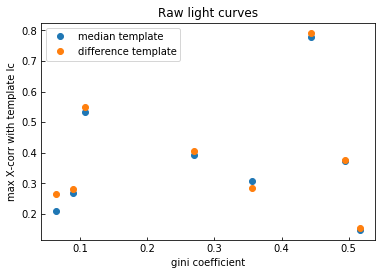

In [12]:
plt.plot(ch35_gini, x_corr_med, 'o', label="median template")
plt.plot(ch35_gini, x_corr_dif, 'o', label="difference template")
plt.xlabel('gini coefficient')
plt.ylabel('max X-corr with template lc')
plt.title ('Raw light curves')
plt.legend()

Trying to find a relationship between the "strength" of the systematics and how extended a source is (how in-focus it appears). There is no clear relationship in these 8 data points.

### Try it with the EVEREST lightcurves

In [14]:
# arrays to save results in 
x_corr_med_eve = np.zeros_like(np.array(ch35.magnitude))
x_corr_dif_eve = np.zeros_like(np.array(ch35.magnitude))

campaign = 8 
for index,epic in enumerate(np.array(ch35['EPIC ID'])):
    lc_everest = everest.Everest(epic, season=8)
    
    # get mask of bad cadences
    mask = np.isin(np.arange(3852+1), np.concatenate([lc_everest.nanmask, lc_everest.badmask, lc_everest.mask]))
    
    # extract magnitude
    mag = np.array(ch35.magnitude)[index]
    
    # calculate which magnitude bin object falls into
    ind = np.where((mag - mag_med_bin_edges) < 0)[0][-1]

    # extract proper template lc for that magnitude
    template_lc_med = temp_med[:,ind]
    template_lc_dif = temp_diff[:,ind]    
    
    # calculate max X-corr
    x_corr_med_eve[index] = np.max(norm_xcorr(lc_everest.flux[~mask], template_lc_med[~mask]))
    x_corr_dif_eve[index] = np.max(norm_xcorr(lc_everest.flux[~mask], template_lc_dif[~mask]))

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 220212788.
INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 220212670.
INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 220220757.
INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 220221035.
INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 220192831.
INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 220216359.
INFO  [everest.user.DownloadFile()]: Downloading the file...
ERROR [everest.user.DownloadFile()]: Error code 0 for URL 'https://archive.stsci.edu/hlsps/everest/v2/c08/220100000/98775/hlsp_everest_k2_llc_220198775-c08_kepler_v2.0_lc.fits'


Exception: Unable to locate the file.

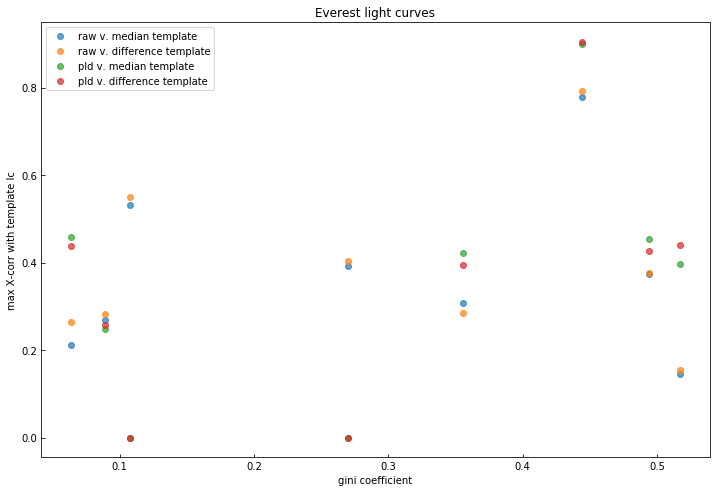

In [15]:
sort = np.array(ch35_gini).argsort()

plt.figure(figsize=(12,8))
plt.plot(ch35_gini[sort], x_corr_med[sort], 'o', label="raw v. median template", alpha=0.7)
plt.plot(ch35_gini[sort], x_corr_dif[sort], 'o', label="raw v. difference template", alpha=0.7)
plt.plot(ch35_gini[sort], x_corr_med_eve[sort], 'o', label="pld v. median template", alpha=0.7)
plt.plot(ch35_gini[sort], x_corr_dif_eve[sort], 'o', label="pld v. difference template", alpha=0.7)
plt.xlabel('gini coefficient')
plt.ylabel('max X-corr with template lc')
plt.title ('Everest light curves')
plt.legend()

The two points that are at 0.0 for pld were not computed. Disregarding them, it there isn't a clear relationship from these 6 data points.

---
### See Ed Shaya Galaxies 

Want to do the same analysis for Ed Shaya galaxies in K2 campaign 8, since there are more objects (ideally atleast 50 objects).

In [2]:
# create a random sample of Ed Shaya galaxies 
shaya_df = pd.read_csv("object_keys/c8_shaya.csv")

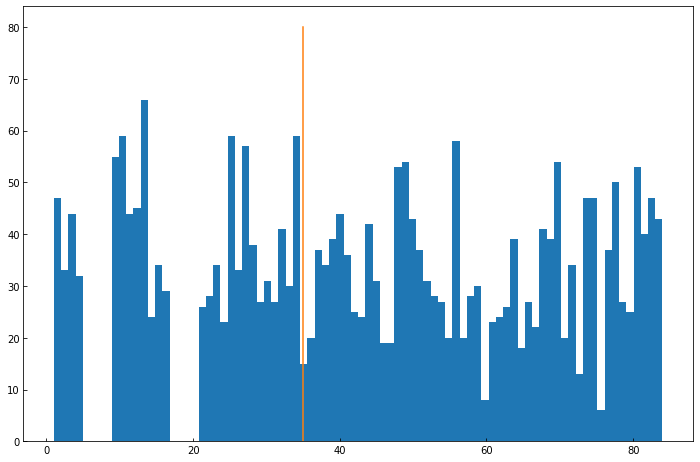

In [66]:
plt.figure(figsize=(12,8))
plt.hist(np.array(shaya_df["CHANNEL"]), bins=np.max(np.array(shaya_df["CHANNEL"])))
plt.plot([35,35],[0,80])

**WELP it looks like channel 35 only has 15 shaya objects. We want atleast 50. **

We need to look at either ch 13 (4 AGN, 66 shaya) or ch 81 (4 AGN, 53 shaya). Channel 13 seems to have clearer systematics than channel 81, so **we'll use 13.**

In [3]:
# cut to channel 13
channel = 13
shaya_ch = shaya_df[shaya_df["CHANNEL"]==channel]

I saved flux, time, mask, fluxerr (for raw flux) in a separate folder.

In [4]:
# load this random sample of 50 objects
shaya_rand_df = pd.read_csv("object_keys/c8_shaya_ch13_random50.csv")

# load the raw light curves
shaya = np.load('../c8_shaya_lc.npy')
shaya_sc = np.load('../c8_shaya_spur_cad.npy').astype(bool) 
shaya_gini = np.load('../c8_shaya_gini.npy')

# load the template light curves
all_channels_df = pd.read_pickle("../template_lcs/k2_c08_CCD_systematics.pkl")
channelMask = (all_channels_df.channel == channel)

In [16]:
from save_everest import load_data

# arrays to save results in 
x_corr_shaya= np.zeros_like(np.array(shaya_rand_df.magnitude))
x_corr_eve_shaya = np.zeros_like(np.array(shaya_rand_df.magnitude))


# run both calculations at the same time
for index, epic in enumerate(np.array(shaya_rand_df['EPIC ID'])):
    
    # ----------------------cut to raw lc ---------------------
    mask = (shaya_df['EPIC ID']==epic)
    lc_raw = shaya[mask][0]
    spurious_cad = shaya_sc[mask][0]


    # interp spurious cadences 
    cadno = np.arange(len(lc_raw)) # get an array to serve as our time/cadence measurement

    interped_vals = np.interp(cadno[spurious_cad], cadno[~spurious_cad], lc_raw[~spurious_cad])
    # replace spurious cadence values with the interpolated values
    lc_raw[spurious_cad] = interped_vals
    
    
    # ---------------------load the de-trended light curves ---------------------
    lc_eve, sc, bad, nan = load_data(epic, 8)
    
    # sort flux by time 
    t_eve, f_eve = sort_by_time(np.array(lc_eve.time), np.array(lc_eve.flux))
        
    # calculate mask for bad cadences
    mask_eve = (np.isin(np.arange(3852+1), np.concatenate([sc, bad, nan])))
    
    # interp bad cadences 
    cadno = np.arange(len(f_eve)) # get an array to serve as our time/cadence measurement

    interped_vals = np.interp(cadno[mask_eve] , cadno[~mask_eve], f_eve[~mask_eve])
    # replace spurious cadence values with the interpolated values
    f_eve[mask_eve] = interped_vals
    
                        
    # ---------------------load the template lc ---------------------
    mag = shaya_df.magnitude[mask].values[0]
    
    magnitudeMask = (np.abs(all_channels_df[channelMask].magnitude-mag)).idxmin()

    temp_flux = np.array(all_channels_df.iloc[magnitudeMask][:-4])
    temp_time = np.arange(len(temp_flux))/48.0 # converting to days, starting at zero
    
    
    # ----------------------calculate the x-corr ---------------------
    
    # It has come to my attention that the lk lightcurves have missing cadence points
    # so, I need to make the template light curve smaller (using c8_lk_mask that was already calculated)
    
    x_corr_shaya[index] = np.max(norm_xcorr(lc_raw, temp_flux[c8_lk_mask]))
    
    
    x_corr_eve_shaya[index] = np.max(norm_xcorr(f_eve, temp_flux[mask_eve]))


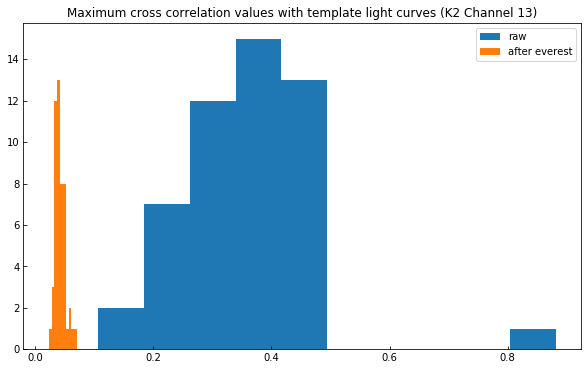

In [17]:
plt.figure(figsize=(10,6))
plt.hist(x_corr_shaya, label='raw')
plt.hist(x_corr_eve_shaya, label='after everest')
plt.title("Maximum cross correlation values with template light curves (K2 Channel %s)"%channel)
plt.xlabel("Max X-corr value")
plt.ylabel("counts")
plt.legend()

They are less correlated than before. But it's important to note that we're taking the maximum of the cross-correlation, not a median!

What do some of these light curves look like after EVEREST?

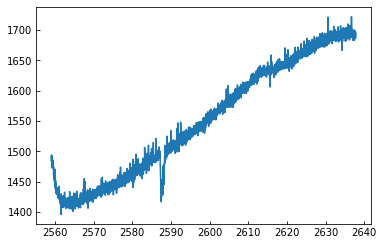

In [80]:
epic = np.array(shaya_rand_df['EPIC ID'])[10]

lc_eve, sc = load_data(epic, 8)

# sort flux by time 
t_eve, f_eve = sort_by_time(np.array(lc_eve.time), np.array(lc_eve.flux))

# calculate spurous cadences
sc_new = mask_spurious(t_eve,f_eve)

# interp spurious cadences 
cadno = np.arange(len(f_eve)) # get an array to serve as our time/cadence measurement

interped_vals = np.interp(cadno[sc_new] , cadno[~sc_new], f_eve[~sc_new])
# replace spurious cadence values with the interpolated values
f_eve[sc_new] = interped_vals


plt.plot(t_eve, f_eve)


In [71]:
# what does the cross-correlation look like (for raw)?
# does the max occur when lag=0 ? 

epic = shaya_rand_df['EPIC ID'][24]

# ----------------------cut to raw lc ---------------------
mask = (shaya_df['EPIC ID']==epic)
lc_raw = shaya[mask][0]
spurious_cad = shaya_sc[mask][0]


# interp spurious cadences 
cadno = np.arange(len(lc_raw)) # get an array to serve as our time/cadence measurement

interped_vals = np.interp(cadno[spurious_cad], cadno[~spurious_cad], lc_raw[~spurious_cad])
# replace spurious cadence values with the interpolated values
lc_raw[spurious_cad] = interped_vals


# ---------------------load the template lc ---------------------
mag = shaya_df.magnitude[mask].values[0]

magnitudeMask = (np.abs(all_channels_df[channelMask].magnitude-mag)).idxmin()

temp_flux = np.array(all_channels_df.iloc[magnitudeMask][:-4])
temp_time = np.arange(len(temp_flux))/48.0 # converting to days, starting at zero

# ----------------------calculate the x-corr ---------------------

# It has come to my attention that the lk lightcurves have missing cadence points
# so, I need to make the template light curve smaller (using c8_lk_mask that was already calculated)
test = norm_xcorr(lc_raw, temp_flux[c8_lk_mask])

# look at the dataframe row 
shaya_df[mask]

,EPIC ID,RA (J2000) [deg],Dec (J2000) [deg],magnitude,Investigation IDs,CHANNEL,IMAGE,MODULE,PIX_COL,PIX_ROW
740,220293806,20.912146,2.50369,16.481,GO8070_LC,13,c8_lcs/220293806.png,6,447,334


max occurs when index lag is 2950.5


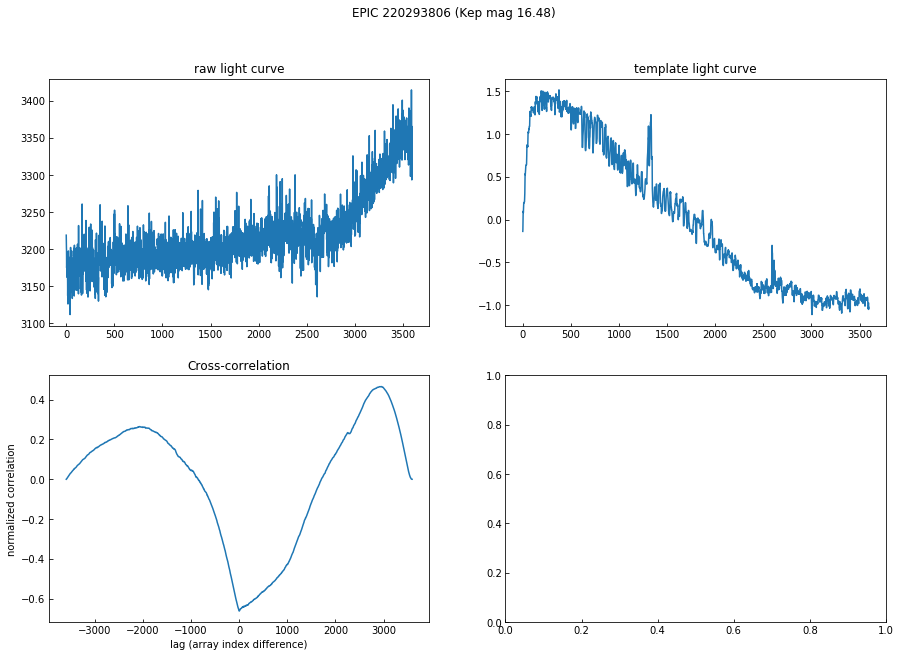

In [69]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("EPIC %s (Kep mag %.2f)"%(epic,mag))

ax[0,0].plot(cadno, lc_raw)
ax[0,0].set_title("raw light curve")

ax[0,1].plot(cadno, temp_flux[c8_lk_mask])
ax[0,1].set_title("template light curve")

ax[1,0].plot(np.arange(len(test)) - len(test)/2, test)
ax[1,0].set_title("Cross-correlation")
ax[1,0].set_xlabel("lag (array index difference)")
ax[1,0].set_ylabel("normalized correlation")

print("max occurs when index lag is %s"%(np.arange(len(test)) - len(test)/2)[np.argsort(test)[-1]])

The correlation with the template light curves went down after the correction, but they didn't really look like the template light curves to begin with (?)

What does it look like for an AGN?

In [2]:
epic = 220179771
campaign = 8 

df = pd.read_csv("object_keys/c8_agn_w_redshift.csv")
mag = df.magnitude[df['EPIC ID']==epic].values[0]

In [7]:
# ----------------------raw lc ---------------------
tpf = lk.search_targetpixelfile(epic, campaign=campaign).download() # define tpf

# get raw lightcurve
lc= tpf.to_lightcurve(aperture_mask='all')
_, spurious_cad = lc.flatten().remove_outliers(return_mask=True) # remove spurious cadences

lc_raw = lc.flux
# interpolate 
cadno = np.arange(len(lc_raw)) # get an array to serve as our time/cadence measurement

interped_vals = np.interp(cadno[spurious_cad], cadno[~spurious_cad], lc_raw[~spurious_cad])
# replace spurious cadence values with the interpolated values
lc_raw[spurious_cad] = interped_vals

In [16]:

# ---------------------load the template lc ---------------------
all_channels_df = pd.read_pickle("../template_lcs/k2_c08_CCD_systematics.pkl")
channelMask = (all_channels_df.channel == tpf.channel)


magnitudeMask = (np.abs(all_channels_df[channelMask].magnitude-mag)).idxmin()

temp_flux = np.array(all_channels_df.iloc[magnitudeMask][:-4])
temp_time = np.arange(len(temp_flux))/48.0 # converting to days, starting at zero


# fit slope 

In [ ]:
# ----------------------calculate the x-corr ---------------------
test = norm_xcorr(lc_raw, temp_flux[c8_lk_mask])

max occurs when index lag is -2690.5


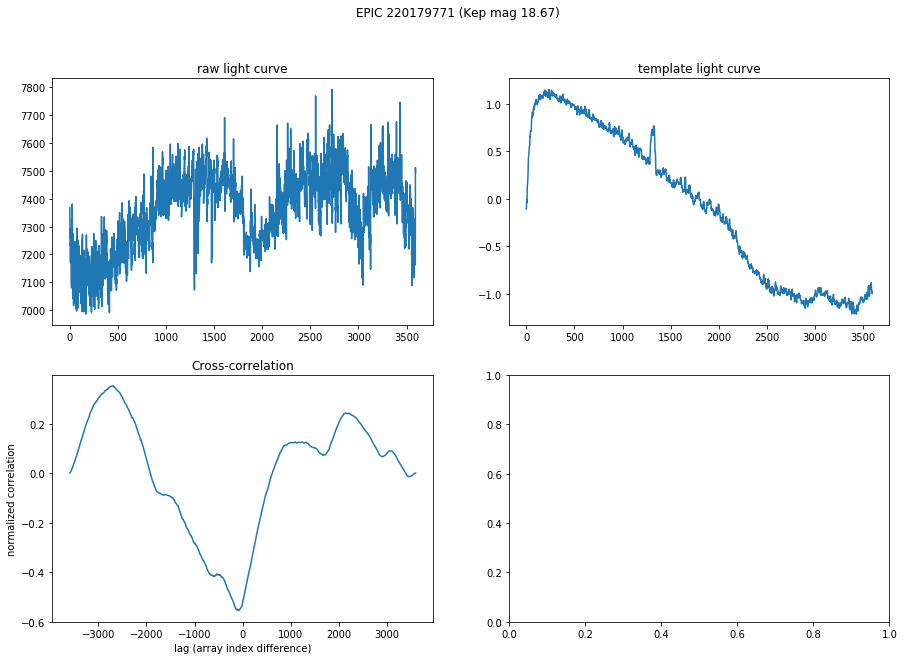

In [17]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
fig.suptitle("EPIC %s (Kep mag %.2f)"%(epic,mag))

ax[0,0].plot(cadno, lc_raw)
ax[0,0].set_title("raw light curve")

ax[0,1].plot(cadno, temp_flux[c8_lk_mask])
ax[0,1].set_title("template light curve")

ax[1,0].plot(np.arange(len(test)) - len(test)/2, test)
ax[1,0].set_title("Cross-correlation")
ax[1,0].set_xlabel("lag (array index difference)")
ax[1,0].set_ylabel("normalized correlation")

print("max occurs when index lag is %s"%(np.arange(len(test)) - len(test)/2)[np.argsort(test)[-1]])

In [18]:
tpf.channel

55

In [20]:
mag

18.666